In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Set up plotting style and suppress warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [5]:
# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [9]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
# Display dataset shape (rows and columns)
print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")

Train dataset shape: (891, 12)
Test dataset shape: (418, 11)


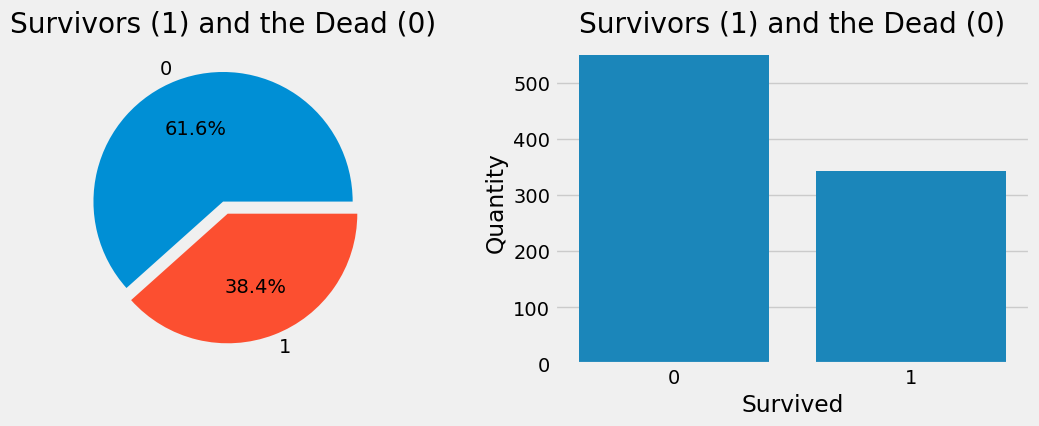

In [13]:
# Visualize survivors and deceased in train data
def visualize_survival():
    f, ax = plt.subplots(1, 2, figsize=(12, 4))
    train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=False)
    ax[0].set_title('Survivors (1) and the Dead (0)')
    ax[0].set_ylabel('')
    sns.countplot(x='Survived', data=train, ax=ax[1])
    ax[1].set_ylabel('Quantity')
    ax[1].set_title('Survivors (1) and the Dead (0)')
    plt.show()

visualize_survival()

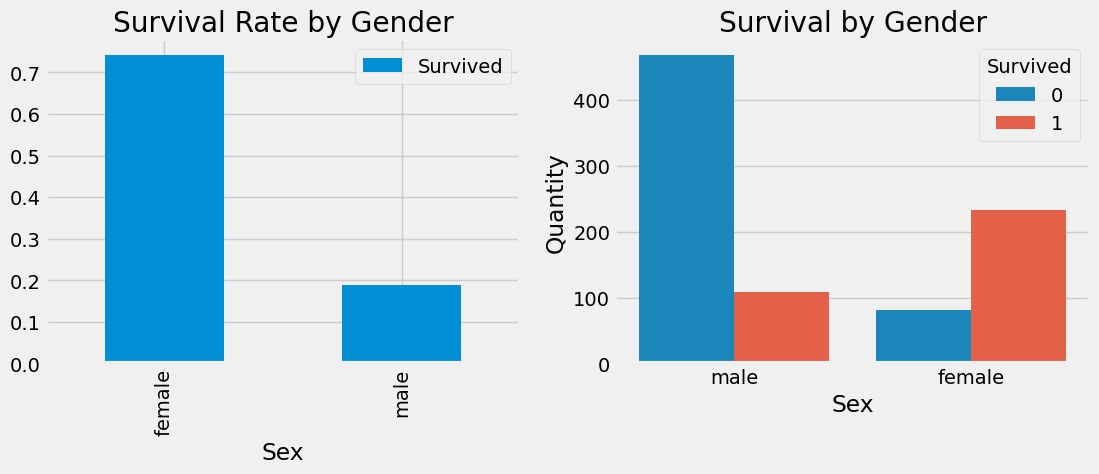

In [15]:
# Visualize survival based on sex
def visualize_gender_survival():
    f, ax = plt.subplots(1, 2, figsize=(12, 4))
    train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
    ax[0].set_title('Survival Rate by Gender')
    sns.countplot(x='Sex', hue='Survived', data=train, ax=ax[1])
    ax[1].set_ylabel('Quantity')
    ax[1].set_title('Survival by Gender')
    plt.show()

visualize_gender_survival()

In [17]:
# Drop columns that aren't needed
train.drop(['Cabin', 'Ticket'], axis=1, inplace=True)
test.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [19]:
# Fill missing values in 'Embarked' with 'S'
train.fillna({'Embarked': 'S'}, inplace=True)

In [21]:
# Handle missing 'Age' values by sorting them into logical categories
def age_grouping(df):
    df["Age"] = df["Age"].fillna(-0.5)
    bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
    labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    df['AgeGroup'] = pd.cut(df["Age"], bins, labels=labels)
    return df

train = age_grouping(train)
test = age_grouping(test)

In [23]:
# Extract titles from names and map them to numeric categories
def process_titles(df):
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
    df['Title'] = df['Title'].replace(['Lady', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].map(title_mapping).fillna(0)
    return df

train = process_titles(train)
test = process_titles(test)

In [25]:
# Map missing 'Age' values based on Title group
def fill_missing_age(df):
    age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}
    for x in range(len(df["AgeGroup"])):
        if df["AgeGroup"][x] == "Unknown":
            df["AgeGroup"][x] = age_title_mapping[df["Title"][x]]
    return df

train = fill_missing_age(train)
test = fill_missing_age(test)

In [27]:
# Map 'AgeGroup' to numerical values
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 'Student': 4, 'Young Adult': 5, 'Adult': 6, 'Senior': 7}
train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

In [29]:
# Drop 'Age' and 'Name' columns as they are no longer needed
train.drop(['Age', 'Name'], axis=1, inplace=True)
test.drop(['Age', 'Name'], axis=1, inplace=True)

In [33]:
# Map 'Sex' and 'Embarked' to numerical values
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

In [35]:
# Fill missing 'Fare' in test dataset
test['Fare'].fillna(test.groupby('Pclass')['Fare'].transform('mean'), inplace=True)

In [37]:
# Map 'Fare' into categories
train['FareBand'] = pd.qcut(train['Fare'], 4, labels=[1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4, labels=[1, 2, 3, 4])

In [39]:
# Drop 'Fare' columns
train.drop(['Fare'], axis=1, inplace=True)
test.drop(['Fare'], axis=1, inplace=True)

In [41]:
# Split the training dataset into training and validation sets
predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train['Survived']

x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size=0.2, random_state=0)

In [43]:
# Train the model using Random Forest
randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)

RandomForestClassifier()

In [45]:
# Predict and evaluate the model
y_pred = randomforest.predict(x_val)
accuracy = round(accuracy_score(y_pred, y_val) * 100, 2)
print(f"Random Forest Accuracy: {accuracy}%")

Random Forest Accuracy: 82.68%


In [47]:
# Make predictions on the test set
test_predictions = randomforest.predict(test.drop('PassengerId', axis=1))

In [53]:
ids = test['PassengerId']
predictions = randomforest.predict(test.drop('PassengerId', axis=1))

# Display the output as a dataframe instead of saving it as a CSV file
output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions})

# Show the first few rows of the output
print(output.head())

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
